In [54]:
#Import necessary libraries to do the data analytics.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [55]:
filename = "SEWorkForJupyter.csv"
data = pd.read_csv(filename , encoding='utf-8')

In [56]:

# Define a function to calculate 'Business Area (Calc)' based on conditions
def calculate_business_area_calc(row):
    business_area = row[' Business Area']
    execution_unit = row['Execution_Unit__c']
    responsible_business_unit = row['Responsible_Business_Unit__c']

    if business_area == "GS" and (execution_unit == "SE GS C" or execution_unit == "SE GS D") and \
       (responsible_business_unit == "SE GP G SV" or responsible_business_unit == "SE GP I SV"):
        return "GS (SV)"
    elif business_area == "GS" and (execution_unit == "SE GS C" or execution_unit == "SE GS D") and \
         (responsible_business_unit != "SE GP G SV" and responsible_business_unit != "SE GP I SV"):
        return "GS (NU)"
    elif business_area == "TI" and execution_unit == "SE TI STG":
        return "TI STG"
    elif business_area == "TI" and execution_unit == "SE TI EAD":
        return "TI EAD"
    elif business_area == "TI" and execution_unit == "SE TI SES":
        return "TI SES"
    elif business_area == "TI" and execution_unit == "SE TI CP":
        return "TI CP"
    else:
        return business_area

In [57]:

# Apply the function to create the 'Business Area (Calc)' column
data['Business Area (Calc)'] = data.apply(calculate_business_area_calc, axis=1)


In [58]:

# Step 2: Calculate Fiscal Year and Fiscal Period_PPT based on CloseDate
def calculate_fiscal_period(row):
    try:
        if row['CloseDate'] != 'NA':
            close_date = pd.to_datetime(row['CloseDate'], format='%m/%d/%Y')
            close_date = close_date.replace(day=1) + pd.offsets.MonthEnd()
            if close_date.month in [10, 11, 12]:
                fiscal_year = close_date.year + 1
                fiscal_quarter = 1
            elif close_date.month in [1, 2, 3]:
                fiscal_year = close_date.year
                fiscal_quarter = 2
            elif close_date.month in [4, 5, 6]:
                fiscal_year = close_date.year
                fiscal_quarter = 3
            elif close_date.month in [7, 8, 9]:
                fiscal_year = close_date.year
                fiscal_quarter = 4
            else:
                fiscal_year = 'NA'
                fiscal_quarter = 'NA'
        else:
            fiscal_year = 'NA'
            fiscal_quarter = 'NA'
    except ValueError:
        fiscal_year = 'NA'
        fiscal_quarter = 'NA'
    return f'FY{fiscal_year} Q{fiscal_quarter}'

In [59]:
# Note This cell takes time to run due to heavy data volume.
data['Fiscal Period_PPT'] = data.apply(calculate_fiscal_period, axis=1)

In [60]:

# Step 3: Filter for Open Opportunities based on 'PM Stage'
open_opportunity_stages = [">PM020", "Negotiation", "PM000", "PM010"]
data_open = data[data['PM Stage'].isin(open_opportunity_stages)]

In [61]:

# Step 4: Calculate 'Forecast (Calc)' based on the given conditions
def calculate_forecast(row):
    if row['Planning Category (Grouped)'] == "Order Forecast" and \
       (row['StageName'] in ["Bid Preparation", "Contract Negotiation", "Lead Management", "Opportunity Development", "Project Handover"] or \
        row['PM Stage'] in [">PM020", "Negotiation", "PM000", "PM010"]):
        return row['Amount']
    else:
        return 0

data_open['Forecast (Calc)'] = data_open.apply(calculate_forecast, axis=1)

In [62]:

# Step 6: Group data by 'Business Area (Calc)', 'Fiscal Period_PPT', and 'Planning Category (Grouped)'
grouped_data = data_open.groupby(['Business Area (Calc)', 'Fiscal Period_PPT', 'Planning Category (Grouped)']).agg({
    'Amount': 'sum',
    'Forecast (Calc)': 'sum'
}).reset_index()

In [63]:

# Step 7: Create a stacked bar chart
plt.figure(figsize=(14, 10))


<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

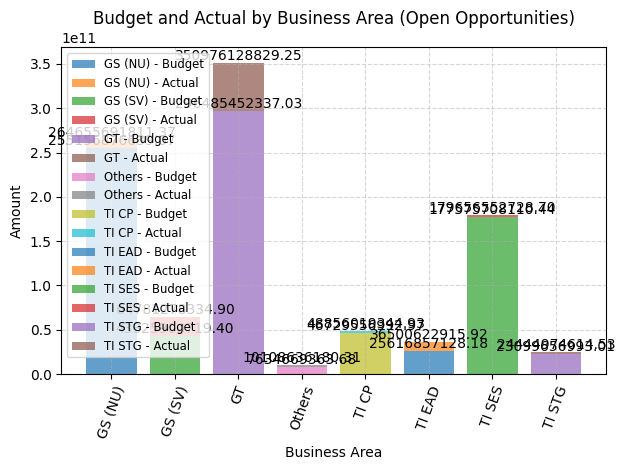

In [64]:

# Get unique Business Areas
business_areas = grouped_data['Business Area (Calc)'].unique()

# Initialize positions for Business Areas on the x-axis
x_positions = list(range(len(business_areas)))

# Loop through each Business Area (Calc)
for i, business_area in enumerate(business_areas):
    area_data = grouped_data[grouped_data['Business Area (Calc)'] == business_area]

    # Calculate the total budget for the Business Area
    total_budget = area_data['Amount'].sum()

    # Calculate the total actual for the Business Area
    total_actual = (area_data['Amount'] + area_data['Forecast (Calc)']).sum()

    # Plot Budget as a bar for the Business Area
    budget_bar = plt.bar(i, total_budget, label=f'{business_area} - Budget', alpha=0.7)

    # Plot Actual as a bar for the Business Area
    actual_bar = plt.bar(i, total_actual - total_budget, bottom=total_budget, label=f'{business_area} - Actual',
                         alpha=0.7)

    # Annotate Budget and Actual values on the bars
    for bar, y_value in zip([budget_bar, actual_bar], [total_budget, total_actual]):
        plt.annotate(f'{y_value:.2f}', (i, y_value), ha='center', va='bottom')

# Set x-axis labels and tick positions
plt.xticks(x_positions, business_areas, rotation=70)

plt.xlabel('Business Area')
plt.ylabel('Amount')
plt.title('Budget and Actual by Business Area (Open Opportunities)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()